# SV1 Vtx Mass #

In SV1, the secondary vertex is uniquely defined, so the goals for this study are to 

1. Gain some understanding for how this problem changes at the reco level
2. Fit a line for the flight direction of the verteices using an optimization function 
3. Modify the cost function to fit a line that minimizes the pT.
4. Play with some different cost functions to see how the performance is increased.

Nicole Hartman
Aug 2017


In [95]:
filepath  = '/atlas/local/BtagOptimizationNtuples/user.giacinto.mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75.BTagNtuples.May22.JetFitterStudies.v02_Akt4EMTo/user.giacinto.11401650.Akt4EMTo._00000?.root'

In [96]:
import numpy as np
import pandas as pd
import sys

# matplotlib includes
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map palatte
from matplotlib.colors import LogNorm

# rootpy functions
from root_numpy import root2array
from rootpy.vector import LorentzVector,Vector3

# useful functions that I've used in different notebooks stored in a other modules
from dataHandling import root2pandas, flatten
from getTruthHists import plotTruthVertexMass

# ML functions
from scipy.optimize import minimize, fsolve

# Data maipulation

Take the data file from the filepath, and create a more user friendly dataframe

In [97]:
'''
Function to calculate the 3 vector for the charged trks from the SV1 algorithm

Inputs: track variables associated to a given jet (assumed to have a SV)
    jet_trk_pt:   np array of tracks pts
    jet_trk_eta:  track etas
    jet_trk_phi:  track phis
    jet_trk_alg:  binary number for which algorithms use this track, the 4th bit corresponding to SV1
Outputs:
    The charged particles px,py, and pz 
'''
def p_ch_SV1(jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_alg):
    
    # Initialize the Vector to 0s
    p  = Vector3(0,0,0)
    pi = Vector3(0,0,0)

    for trk_pt,trk_eta,trk_phi,trk_alg in zip(jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_alg):

        # Check don't use tracks not used by SV1
        if trk_alg & 0b1000 == 0:
            continue

        pi.SetPtEtaPhi(trk_pt,trk_eta,trk_phi)
        p = p + pi

    # Scale from MeV to GeV
    p = p*0.001
    return p.Px(),p.Py(),p.Pz()


In [98]:
# A couple of other useful functions for caluclating p_perp and the corrected mass

# Calculate the perpendicular component of a vector, p, w/r.t. another vector, r
p_perp = lambda p,r : np.linalg.norm( np.cross(p,r), axis=1)/np.linalg.norm(r,axis=1)

# The corrected mass formula (depends on the invar mass of the chgd p'cles and the perpendicular
# component of the charged p'cles)
m_corr = lambda m,pt: np.sqrt(np.power(m,2) + np.power(pt,2)) + pt

In [99]:
loadData = False

if not loadData:

    # Select the branches that you want for this calculation
    jet_sv1_branches = ['PVx','PVy','PVz',
                        'jet_sv1_Nvtx','jet_sv1_vtx_x','jet_sv1_vtx_y','jet_sv1_vtx_z','jet_sv1_vtxm',
                        'jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5',
                        'jet_LabDr_HadF','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']

    # Convert the Ntuple to an nd array
    data = root2array(filepath,branches=jet_sv1_branches)

    # Go from an ndarray to a pandas data frame
    sv1_df = pd.DataFrame(data)

    # First need to convert the event level PV to jet level varaibles
    for newColumn in ['PVx','PVy','PVz']:
        sv1_df[newColumn] =  [map(lambda n_vertices: PV_x, n_vertices ) for (_, (PV_x,n_vertices))  in sv1_df[[newColumn,'jet_sv1_Nvtx']].iterrows()]

    # Flatten the array to jet level variables
    sv1_df_flat = pd.DataFrame({k: flatten(c) for k, c in sv1_df.iteritems()})
    sv1_df_flat = sv1_df_flat[sv1_df.keys()][sv1_df_flat['jet_sv1_Nvtx']==1]
    sv1_df_flat.reset_index(inplace=True)

    # The variables in SV1 are actually stored in lists (even though there is only 1 SV / jet), so need
    # to flatten these variables one more time
    columnsToFlatten = [key for key in sv1_df.keys() if key.startswith('jet_sv1_') and 'Nvtx' not in key]
    for col in columnsToFlatten:   
        sv1_df_flat[col] =  flatten(sv1_df_flat[col]) 

    # Store the inverse of the covariance as an np.matrix
    sv1_df_flat['CovI'] = pd.Series(map(lambda cov: np.matrix([[cov[0],cov[1],cov[3]],[cov[1],cov[2],cov[4]],[cov[3],cov[4],cov[5]]]).I, 
          sv1_df_flat[['jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5']].values))

    # Get the flight direction (could probably do this in a for loop)
    sv1_df_flat['r0_x'] = sv1_df_flat['jet_sv1_vtx_x'] - sv1_df_flat['PVx'] 
    sv1_df_flat['r0_y'] = sv1_df_flat['jet_sv1_vtx_y'] - sv1_df_flat['PVy'] 
    sv1_df_flat['r0_z'] = sv1_df_flat['jet_sv1_vtx_z'] - sv1_df_flat['PVz'] 

    # Get the vector for the charged particles
    p_arr = np.array(map(lambda args: p_ch_SV1(*args), sv1_df_flat[['jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']].values))
    sv1_df_flat['p_x'] = p_arr[:,0]
    sv1_df_flat['p_y'] = p_arr[:,1]
    sv1_df_flat['p_z'] = p_arr[:,2]

    # Get the direction of pt rel to the flight path
    sv1_df_flat['pt'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,sv1_df_flat[['r0_x','r0_y','r0_z']].values))

    # Scale the vtx mass to GeV
    sv1_df_flat['m_ch'] = sv1_df_flat['jet_sv1_vtxm'].apply(lambda x: x*0.001)

    # Final (super exciting) step: Find the corrected mass :D
    sv1_df_flat['m'] = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt']) )

    # Delete the columns that you don't want to save
    del_cols = ['jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5',
               'jet_sv1_vtxm','index','jet_sv1_Nvtx','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']
    for col in del_cols:
        del sv1_df_flat[col]

    # Rename some columns 
    sv1_df_flat.rename(index=str, columns={"jet_sv1_vtx_x": "SVx", "jet_sv1_vtx_y": "SVy", 
                                           "jet_sv1_vtx_z": "SVz", "jet_LabDr_HadF": "jet_pdg"},inplace=True)

# if loadData is True, load a previously formatted SV1 dataframe from an HDF5 file
else:
    sv1_df_flat = pd.read_hdf('sv1_df.h5', 'data')

In [100]:
# Look at the resultant df
sv1_df_flat[:3]

,PVx,PVy,PVz,SVx,SVy,SVz,jet_pdg,CovI,r0_x,r0_y,r0_z,p_x,p_y,p_z,pt,m_ch,m
0,-0.493256,-0.510917,1.146830,1.777389,0.201947,7.338430,5,[[[[[ 1314.8614502 -345.84637451 -401.09713...,2.270646,0.712864,6.191600,11.263325,4.186994,32.702732,0.817702,1.400951,2.439830
1,-0.496530,-0.504810,-38.849056,-6.995791,-0.692624,-41.068386,5,[[[[[ 109.88780212 -668.6161499 -205.19377136...,-6.499261,-0.187814,-2.219330,-39.950900,-1.291633,-12.365977,1.216829,2.316980,3.833903
2,-0.496530,-0.504810,-38.849056,-4.370488,1.119755,-46.568710,5,[[[[[ 889.78179932 215.13705444 -380.72607422...,-3.873958,1.624565,-7.719654,-9.446460,4.116998,-19.428242,0.276161,0.967002,1.281824


In [101]:
'''
Make a function that overlays the variables for the different cuts we can impose.

Inputs: 
    (1) Strings correspondings to the names of the cols of interest, i.e,
        m_ch, m, and pt
    (2) suffix: a string suffix to be appended to the titles 

'''
def overlayCuts(m_ch='m_ch', m='m', pt='pt',suffix=""):

    pdg_ids = [0,4,5,15]
    titles  = ['light jets','charm jets','b jets','tau jets']

    min = 0
    max = 10
    Nbins = 40
    range = (min,max)

    for pdg_id,title in zip(pdg_ids,titles):

        if suffix != "":
            title = "{0}: {1}".format(title,suffix)
                
        # set up your figures
        fig = plt.figure(figsize=(6, 4), dpi=100)

        plt.hist(sv1_df_flat[m_ch][sv1_df_flat['jet_pdg']==pdg_id],
                 label='$M_{ch}$', color='r',
                 histtype='step',bins=Nbins,range=range)
        plt.hist(sv1_df_flat[m][sv1_df_flat['jet_pdg']==pdg_id],
                 label='$M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='b',
                 histtype='step',bins=Nbins,range=range)
        plt.hist(sv1_df_flat[m].where(sv1_df_flat[m] < 2*sv1_df_flat[m_ch],other=sv1_df_flat[m_ch])[sv1_df_flat['jet_pdg']==pdg_id],
                 label='$M < 2 M_{ch}$', color='g',
                 histtype='step',bins=Nbins,range=range)
        plt.hist(sv1_df_flat[m].where(sv1_df_flat[pt] < sv1_df_flat[m_ch],other=sv1_df_flat[m_ch])[sv1_df_flat['jet_pdg']==pdg_id],
                 label='$p_\perp < M_{ch}$', color='m',
                 histtype='step',bins=Nbins,range=range)

        # prettify your histograms
        plt.xlabel('Vtx mass [GeV]')
        plt.ylabel('Events')
        plt.title(title)
        plt.legend()
        plt.show()


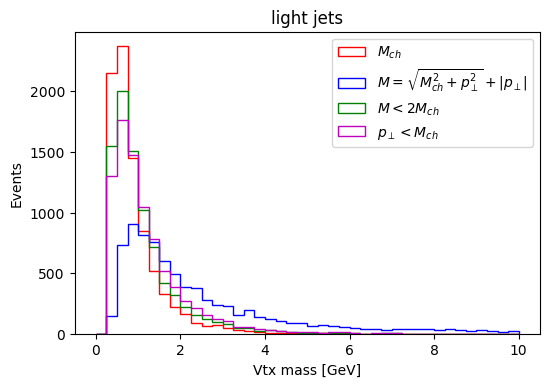

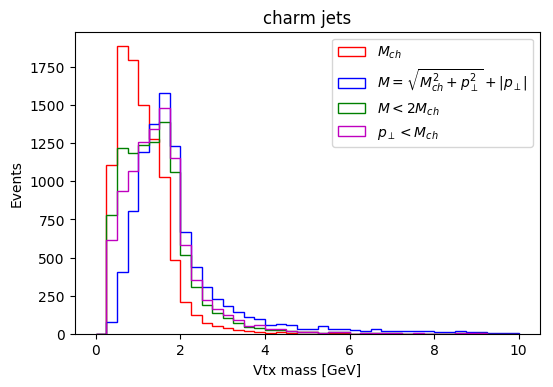

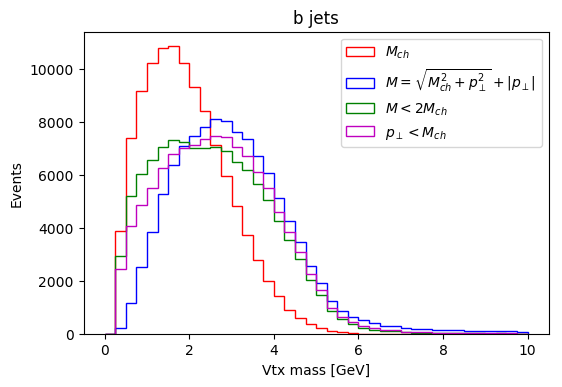

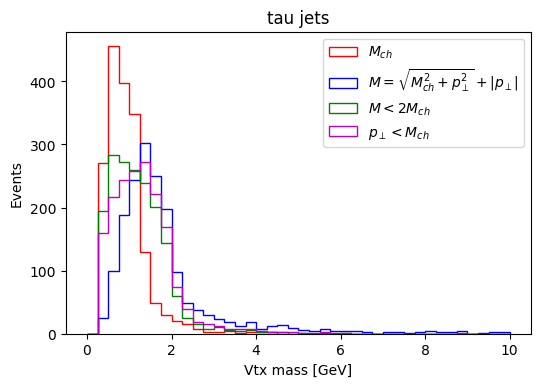

In [102]:
# Plots for the naive implementation of the formula w/o "wiggling" the SV position based on the errors

overlayCuts()

# Finding the flight direction by minimizing a cost function

Let $x_{PV}, x_{SV} \in \mathbb{R}^3$ denote the positions of the primary and secondary vertices, and $\Sigma \in \mathbb{R}^{3\times3}$ be the covariance matrix for the secondary vertex.

Let $r \in \mathbb{R}^3$ denote the flight vector of the b-hadron. The likelihood function for $r$ is given by the multi-variate Gaussian pdf: 

\begin{equation}
    \mathcal{L}(r) = p(x_{PV},x_{SV},\Sigma; r) = \frac{1}{(2\pi)^{3/2} |\Sigma|} \exp \left[ -\frac{1}{2} (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) \right]
\end{equation}

Maximizing this likelihood is equivalent to minimizing  $- 2 \log \mathcal{L}$ 

\begin{equation}
- 2 \log \mathcal{L} =  2 \log \left[ (2\pi)^{3/2} |\Sigma| \right] + (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV})
\end{equation}

Ignoring the constant that doesn't depend on $r$, we can then define the cost function as

\begin{equation}
J(r) = (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV})
\end{equation}

Minimizing this cost function is equivalent to simply setting $r = x_{SV} - x_{PV}$.


# Modifying the Cost function

There are a couple of different ways that we can find the flight direction to minimize $p_\perp$ 

(1) Impose a Bayesian prior on the likelihood assuming that the $p_\perp$ are Gaussian distributed about a mean of 0.

\begin{equation}
    \mathcal{L}(r) = \frac{1}{(2\pi)^{3/2} |\Sigma|} \exp \left[ -\frac{1}{2} (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) \right]
    \sqrt{ \frac{\alpha}{2\pi}} \exp \left( -\frac{\alpha p_\perp^2}{2}  \right)   
\end{equation}

The cost functon is again defined as $-2 \log \mathcal{L}$ (up to a constant)

\begin{align}
J(r) &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \alpha p_\perp^2 \\
     &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \alpha\left( p^2 - \left( \frac{r \cdot p}{r} \right)^2 \right)
\end{align}

This cost function is nice because you can calculate the gradient and the Hessian to minimie the objective using the rapidly converging Newton's method.

(2)  Intead of adding $\alpha p_\perp^2$ to the cost function, could instead add a term proportional to $|p_\perp|$:

\begin{align}
J(r) &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \beta | p_\perp | \\
     &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \beta \frac{|r \times p|}{|r|}
\end{align}

Note: $\alpha$ and $\beta$ are both hyperparameters that I'm free to tune, and I used different variables because they correspond to different scales.
(The function below just accepts one hyperparameter though to simplify the code.)

In [103]:
'''
Minimize J1 / J2 for a given hyperparameter alpha or beta

Global var: alpha / beta: The hyperparameter that defines how aggressively you want to minimize p_perp
            (Needs to be defined outside of this function before it's called.)

Inputs: r0:  An np.array() of length 3 pointing from the PV to the SV
        CovI: 3x3 marix for the inv of the covariance of the SV
        p:   An np.array() of length 3 for the momentum vector of the charged p'cles
        

Ouputs: r = np.array([rx,ry,rz]), the flight vector that minimizes J1

'''
def minimizeJ1(r0,CovI,p):

    invCov = np.array(CovI[0])
    J1    = lambda (r): np.dot(r-r0, np.dot(invCov, r-r0)) + alpha * (np.dot(p,p) - np.dot(r,p)**2/np.dot(r,r))
    delJ1 = lambda(r): 2*np.dot(invCov,r-r0) + 2* alpha * ( np.dot(r,p)**2 / (np.linalg.norm(r)**3) * r - np.dot(r,p) / np.dot(r,r) * p )

    res = minimize(J1,r0,method='BFGS',jac=delJ1)
    
    # I should probably check that the minimizer terminated successfully
    return res.x
    
    
    
def minimizeJ2(r0,CovI,p):
    
    invCov = np.array(CovI[0])
    J2 =  lambda (r): np.dot(r-r0, np.dot(invCov, r-r0)) + beta * np.linalg.norm(np.cross(p,r))/np.linalg.norm(r)

    res = minimize(J2,r0)
    
    return res.x

In [104]:
# Try it out!
alpha=12
r_alpha12 = np.array(map(minimizeJ1 , sv1_df_flat[['r0_x','r0_y','r0_z']].values,
                sv1_df_flat[['CovI']].values,sv1_df_flat[['p_x','p_y','p_z']].values))

# Get the direction of pt rel to the flight path and the corrected mass w/ this new pt
sv1_df_flat['pt_alpha12'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,r_alpha12), index=sv1_df_flat.index)
sv1_df_flat['m_alpha12']  = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt_alpha12']), index=sv1_df_flat.index)


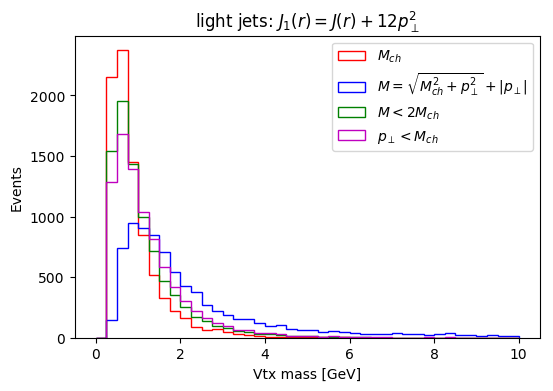

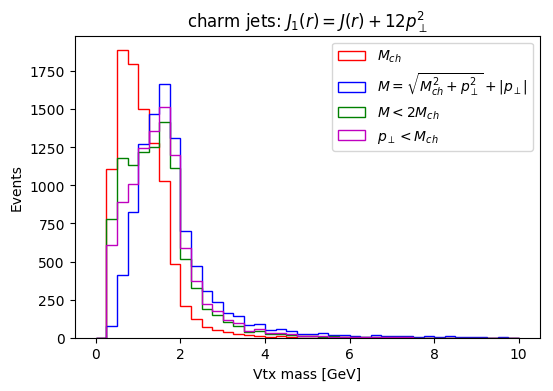

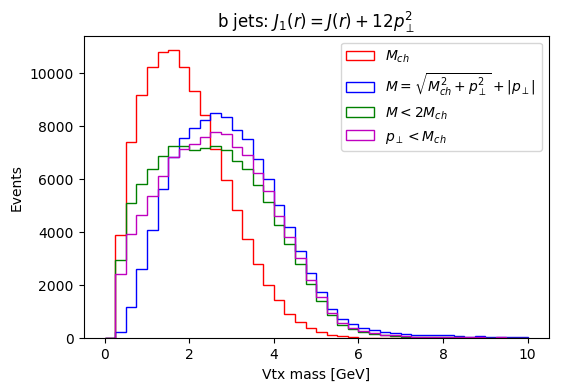

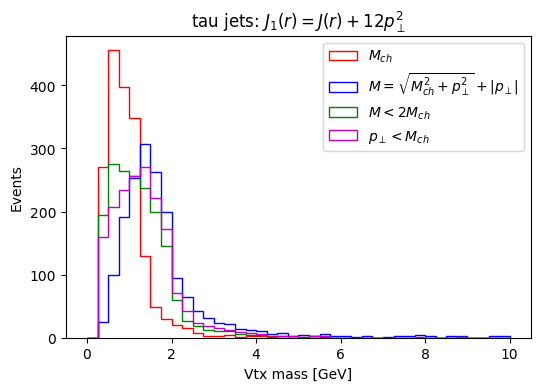

In [105]:
# Plot the histograms minimized via the J1 function
overlayCuts(m='m_alpha12',pt='pt_alpha12',suffix='$J_1(r) = J(r) + {}p_\perp^2$'.format(alpha))

In [106]:
beta = 16
r_beta16 = map(minimizeJ2 , sv1_df_flat[['r0_x','r0_y','r0_z']].values,
                sv1_df_flat[['CovI']].values,sv1_df_flat[['p_x','p_y','p_z']].values)

# Get the direction of pt rel to the flight path and the corrected mass w/ this new pt
sv1_df_flat['pt_beta16'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,r_beta16),index=sv1_df_flat.index)
sv1_df_flat['m_beta16']  = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt_beta16']),index=sv1_df_flat.index )


/nfs/slac/g/atlas/u02/makagan/miniconda3/envs/mlenv2/lib/python2.7/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


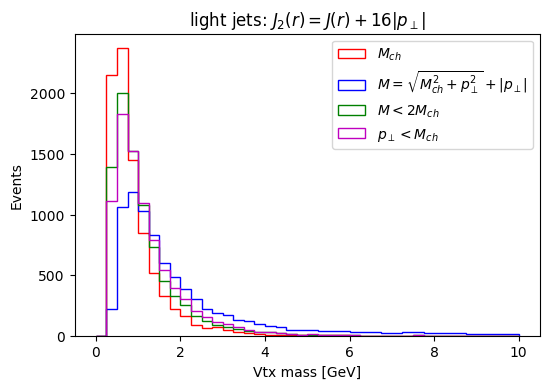

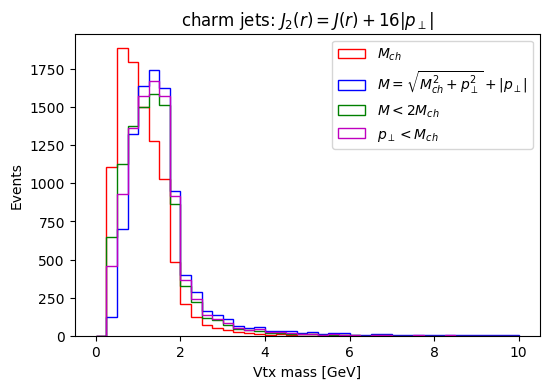

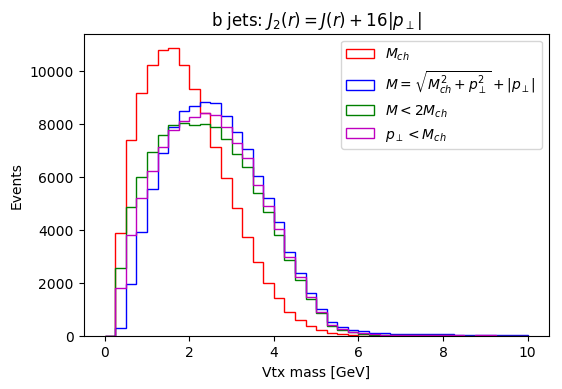

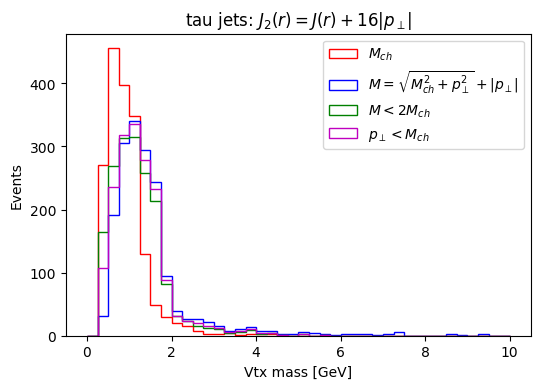

In [107]:
# Plot the histograms minimized via the J2 function
overlayCuts(m='m_beta16',pt='pt_beta16',suffix='$J_2(r) = J(r) + {}|p_\perp|$'.format(beta))

I'm going to repeat the graphs above, but this time with the cut $M < 2 M_{ch}$ for the correction formula to be applied

# Transforming a vector into the z-axis.

Let $r_0 = (x_0,y_0,z_0)$ denote a vector that you want to rotate this into the z-axis. We can do this by applying two succesive rotation matrices.

First apply a rotation $Q_1$ that rotates $r_0$ counter-clockwise about the z-axis by $\theta_1$ to set the x-component of the vector to 0.

\begin{equation}
r_1 = Q_1 r_0 = 
\begin{bmatrix} 
\cos \theta_1 & - \sin \theta_1 & 0 \\
\sin \theta_1 &   \cos \theta_1 & 0 \\
    0         &        0        & 1
\end{bmatrix}
\begin{bmatrix} 
x_0 \\
y_0 \\
z_0
\end{bmatrix}
=
\begin{bmatrix}
0 \\
y_1
z_1 = z_0
\end{bmatrix}
\end{equation}

Solving for $\cos \theta_1$:

\begin{equation}
\cos \theta_1 x_0 - \sin \theta_1 y_0 = 0
\implies x_0^2 \cos^2 \theta_1 = y_0^2 \left( 1 - \cos^2 \theta_1 \right)
\end{equation}

\begin{equation}
\cos \theta_1 = \frac{y_0}{\sqrt{x_0^2 + y_0^2}} 
\qquad \& \qquad 
\sin \theta_1 = \frac{x_0}{\sqrt{x_0^2 + y_0^2}}
\end{equation}

Then we rotate the resultant vector $r_1$ by $Q_2$ into the z-plane. 

\begin{equation}
Q_2 r_1 = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta_2 & - \sin \theta_2 \\
0 & \sin \theta_2 & \cos \theta_2
\end{bmatrix}
\begin{bmatrix}
0 \\ y_1 \\ z_1
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 0 \\ |r_0|
\end{bmatrix}
\end{equation}

Solving for $\theta_2$ is as $\theta_1$ with the substitution $x_0 \rightarrow y_1$ and $y_0 \rightarrow z_1$:
\begin{equation}
\cos \theta_2 = \frac{z_1}{\sqrt{y_1^2 + z_1^2}} 
\qquad \& \qquad 
\sin \theta_2 = \frac{y_1}{\sqrt{y_1^2 + z_1^2}}
\end{equation}

Then $Q = Q_2 * Q_1$ satisfies $Q r = \begin{bmatrix} 0 \\ 0 \\ |r|  \end{bmatrix}$.


In [108]:
'''
rotationMatrix() gets the transfomation matrix that rotates
a vector about two axes.

Input: r0: np.array([x,y,z])
        i: The entry that you're setting to zero
        j: The dimension that you're rotating into
    
Output: An np.matrix R such that r = R*r0 is a vector with 
        r[i] = 0 and r[j] = r0[i]**2 + r0[j]**2, with all other
        entries in r identical to those in r0.

'''
def rotationMatrix(r0,i,j,debug=True):
        
    if debug:
        print "      r0 = {0}, |r0|={1}".format(r0,np.linalg.norm(r0))

    dim = r0.size
    
    # Check that you're not trying to rotate about axes that are out of bounds
    if i >= dim or j >= dim:
        print "Index {0} not allowed for matrix of dim {1}x{1}".format(i if i >= dim else j,dim)
        sys.exit()
    
    R = np.matrix(np.identity(dim))
        
    c1 = r0[j] / np.sqrt(r0[i]**2 + r0[j]**2)
    s1 = r0[i] / np.sqrt(r0[i]**2 + r0[j]**2) 
        
    R[i,i] =  c1
    R[i,j] = -s1
    R[j,i] =  s1
    R[j,j] =  c1
        
    if debug:
        print "R*r0 = {}".format(np.dot(R,r0))

    return R

In [109]:
'''
transformationMatrix() gets the transfomation matrix that rotates
a vector r0 into the z-axis

Input: r0: np.array([x,y,z])
    
Output: An np.matrix Q such that Q*r0 = (0,0,|r0|)

'''
def transformationMatrix(r0,debug=True):
        
    if debug:
        print "      r0 = {0}, |r0|={1}".format(r0,np.linalg.norm(r0))

    Q1 = rotationMatrix(r0,0,1,debug=debug)
    r1 = np.dot(np.array(Q1),r0)
    
    if debug:
        print "   Q1*r0 = {}".format(r1)
        
    # Set the x r0 out of the () plane
    Q2 = rotationMatrix(r1,1,2,debug=debug)
    r2 = np.dot(np.array(Q2),r1)

    if debug:
        print "   Q2*r1 = {}".format(r2)
    # Same answer using the method below... it checks!
    
    Q = Q2 * Q1
    if debug:
        print "Q2*Q1*r0 = {}".format(np.dot(Q,r0))

    return Q
    

Next step: Implement the 1 sigma cut solution, most of the code will be copied and pasted from the LL plots.

In [110]:
'''
Modify the flight direction by moving the SV by 1 sigma.

Same inputs and outputs as the optimizeJ functions.

'''

def SV_1sigma(r0,CovI,p):
    
    # Transform r0 into the z-axis
    Q = transformationMatrix(r0,debug=False)

    # The number of sigmas we're transforming the SV by
    z = 1
    
    # Rotate p_arr into the flight direction of the b-hadron
    p_perp = np.dot(np.array(Q),p)

    # Find the matrix that rotates p_perp to only have a y-component
    R = rotationMatrix(p_perp,0,1,debug=False)

    # Next step: Solve for r at this J(r) = z

    # Rotate r0 by R*Q
    t0 = np.dot(np.array(R*Q),r0)
    Omega = R * Q * CovI[0] * (R*Q).T

    t = t0        
    t[1] = t0[1] + np.sqrt(z / Omega[1,1])   

    # Rotate t back into the lab frame
    r = np.dot(np.array((R*Q).T),t)
    
    return r
    

In [111]:
# Find the r modified by this 1 sigma cut, and use it to find the p_perp and corrected mass
r_z1 = np.array(map(SV_1sigma , sv1_df_flat[['r0_x','r0_y','r0_z']].values,
                sv1_df_flat[['CovI']].values,sv1_df_flat[['p_x','p_y','p_z']].values))

# Get the direction of pt rel to the flight path and the corrected mass w/ this new pt
sv1_df_flat['pt_z1'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,r_z1), index=sv1_df_flat.index)
sv1_df_flat['m_z1']  = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt_z1']), index=sv1_df_flat.index)


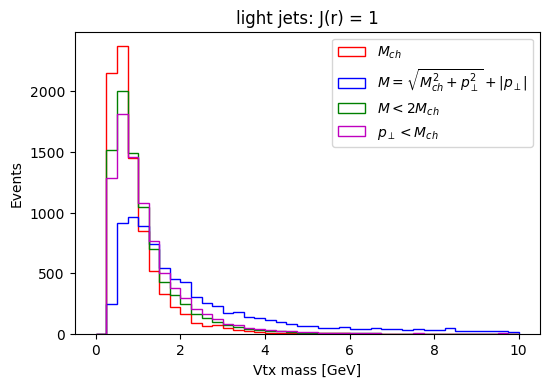

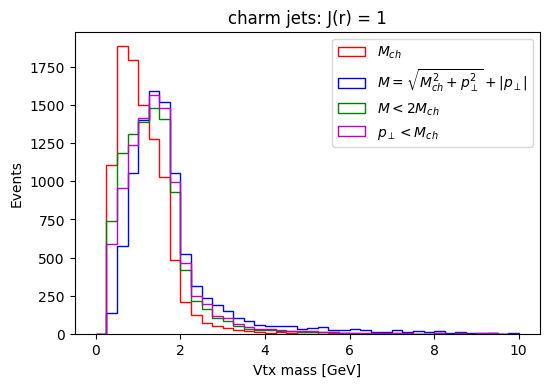

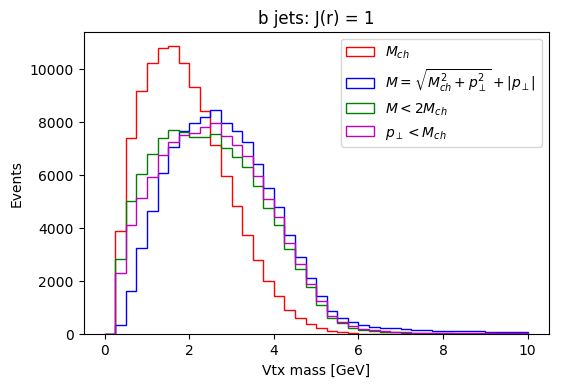

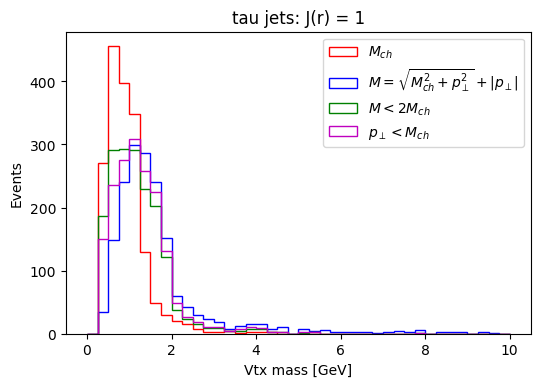

In [112]:
# Overlay the cuts
overlayCuts(m='m_z1',pt='pt_z1',suffix='J(r) = 1')

# Next Steps:
- Could try more $\alpha$s and $\beta$s, but  I'm not sure what is the error function minimize. Maybe a likelihood ratio of either the b vs c or b vs l?

Let Q be the matrix that transforms $r_0 = SV - PV$ into the z direction.


# Making the contour plots for $J(r) = z$ with respect $r_\perp$ and $p_\perp$ axes

Solving J(r) = z is equivalent to minimizing $F(r) = (J(r)-z)^2$. The solution space is in general an ellipsoid. However, since we're trying to find a new $r$ that minimizes the $p_\perp$, and in particular, look for the solution on the 2D plane,
I imposed an additional constraint that the new solution vector $r$ had the same component along the direction of $b_H$ as $r_0$, i.e, $\langle Qr|Qr_0 \rangle = \langle Q r_0|Q r_0 \rangle \implies \langle r|r_0 \rangle = \langle r_0 | r_0 \rangle$.

So to try to incorporate this constraint, I wrote the cost function in a different basis.

\begin{align}
J(r) &= (r-r_0)^T \Sigma^{-1} (r-r_0) \\
     &= (r-r_0)^T Q^T Q \Sigma^{-1} Q^T Q (r-r_0) \\
     &= (Q r - Q r_0)^T Q \Sigma^{-1} Q^T (Q r - Q r_0) \\
     &= (s - s_0)^T \Xi (s - s_0)
\end{align}

where I've defined new variables in the basis of the hadron as $s \equiv Qr$, $s_0 \equiv Qr_0$, $\Xi = Q \Sigma^{-1} Q^T$.

Then partition these vectors as
\begin{equation}
s = \begin{bmatrix} s_\perp \\ s_{||} \end{bmatrix}, \qquad
s_0 = \begin{bmatrix} 0 \\ s_0 \end{bmatrix}, \qquad
\Xi = \begin{bmatrix}\Xi_\perp \quad & \Xi_* \\ \Xi_* \quad & \Xi_{||}  \end{bmatrix}
\end{equation}

Then $ \langle s,s_0 \rangle = s_\perp \cdot 0 + s_{||} s_0 = s_0^2 \implies s_{||} = s_0$.

So $s - s_0 = \begin{bmatrix} s_\perp \\ 0 \end{bmatrix}$, and carrying out the block matrix multiplication simplifies our problem to being in only two dimensions:

\begin{equation}
J(s) = \begin{bmatrix} s_\perp^T \quad 0 \end{bmatrix}
\begin{bmatrix} \Xi_\perp \quad & \Xi_* \\ \Xi_* \quad & \Xi_{||}  \end{bmatrix}
\begin{bmatrix} s_\perp \\ 0 \end{bmatrix}
= s_\perp^T \Xi_\perp s_\perp
\end{equation}

\begin{equation}
\nabla_s (J(s) - z)^2 = 2(J(s) - z) \nabla_s J(s) = 4 (J(s) - z) \Xi_\perp s_\perp
\end{equation}

So this gradient doesn't change anything in the flight direction.

Then for some initial guess, the minimizer will return a s value. Transform $s$ back to the lab frame to get a solution $r = Q^T s$. 

Then to get $p_\perp$ with respect to the new axis, I found the $Q'$ for the flight direction along r, and then applied $Q' * p = \begin{bmatrix} p_{\perp 1} \\ p_{\perp 2} \\ p_{||} \end{bmatrix}$.

Then to get the whole contour of solutions, I passed in a range of different initial guesses for $r$, and concentric squares as inititial guesses for r allowed me to fill out the ellipse of solutions in $r_\perp$ and get a connected contours for $s_\perp$ as well. 


In [113]:
'''
Function 'getInitialGuess()' returns the initial guesses for flight direction r found 
from solving the equation J(r)=z.
From trying a few different choices for initial guesses, it seemed like
two concentric squares allowed full coverage of the solution vector curve

I've done a bit of tuning to adjust the boxes to be the right size to get
the cover the allowed rs.

Inputs:
    z:           Float - the sigma for which this contour was generated
    N:           Integer - the number points along each side of the square
    x3:          The z coordinate for the position (along the flight axis)
                 Note: The solution to minimizer is currently dependent
                 on having the z value correct.
    drawSquares: Boolean - True if you want to plot the initial guess
    drawSolnR:   Boolean - True if the solution to the minimizer should be
                 plotted along with the initial guess.
Outputs:
    items:     A list of dimensions (8*(N+1), 3) for the (x,y,z) positions
               for the initial guesses to be passed to the minimizer.
               The factor of 8 is for the 8 sides of the two squares
'''
def getInitialGuess(z=1,N=10,x3=0,drawSquares=True,drawSolnR=False):
    
    if z > 0.8:
        boxSizes = [0.01,0.02,0.03]
    elif z > .6:
        boxSizes =[0.02,0.025,0.0275]
    elif z > .4:
        boxSizes =[0.01,0.015,0.02]
    else:
        boxSizes =[0.012,0.019]

    # Change the dimensions of this var depending on what z is passed in
    
    boxColors  = ['c','g','m']
    solnColors = ['r','b','k']
    
    items = []
    
    if drawSquares or drawSolnR:
        plt.figure(figsize=(5, 5))
    
    for boxSize,boxColor,solnColor in zip(boxSizes,boxColors,solnColors):
        l1 = np.linspace(-boxSize,boxSize,N)
        l2 = boxSize*np.ones(N)
        myItems = map(lambda x,y: (x,y,x3), np.concatenate([l1,l2,l1,-l2]),np.concatenate([l2,l1,-l2,-l1]))
        
        # Draw the lines - if requested
        if drawSquares:
            plt.scatter(np.array(myItems)[:,0],np.array(myItems)[:,1],label="Intial guess, s = {}".format(boxSize),color=boxColor)

        # Note: The cell below needs to be executed before
        if drawSolnR:
            results = np.array( map(lambda si: minimize(J_z1_Sqd , si, jac=delJ_Sqd).x, myItems) )
            plt.scatter(results[:,0],results[:,1],label="Soln r for r0 from s = {} square".format(boxSize),color=solnColor)
        
        # Append to items
        items = items + myItems

    # If a figure was drawn, display it 
    if drawSquares or drawSolnR:
        # Add labels for the x and y axis
        plt.title('z = {0}; # points / line seg = {1}'.format(z,N))
        plt.xlabel('$r_{\perp 1}$')
        plt.ylabel('$r_{\perp 2}$')
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        
    # Don't bother showing the figure if you're calling the function
    # from the optimizeJ function.
    if drawSolnR:
        plt.show()

    return items
 

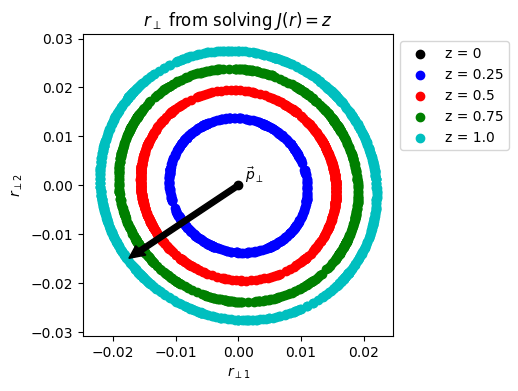

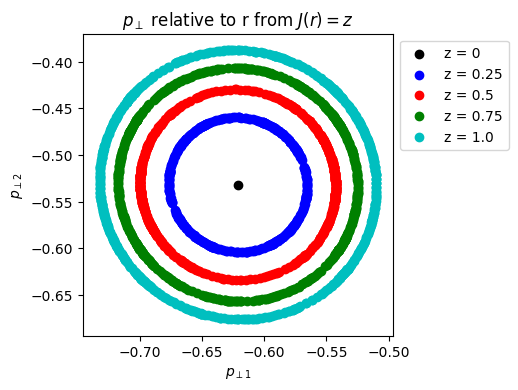

In [114]:
# Make the contour plots for the solution of ellipses satisfying J(r) = z perpendicular the dir of the hadron
plt.close()

invCov = sv1_df_flat['CovI'][0]

# Initialize the flight direction of the b-hadron to the SV - PV
# It turns out that the first event that has a SV is a b-hadron
r0 = sv1_df_flat[['SVx','SVy','SVz']].values[0] - sv1_df_flat[['PVx','PVy','PVz']].values[0]
Q = transformationMatrix(r0,debug=False)
r2 = np.dot(np.array(Q),r0)
        
# Solve for the vector s_perp
Chi = Q * invCov * Q.T

# Plot the center of the ellipse
fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
#plt.figure(1)
plt.scatter(r2[0],r2[1],color='k',label='z = 0')

# Define the p_perp plot outside of the for loop
fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
#plt.figure(2)
p_arr = sv1_df_flat[['p_x','p_y','p_z']].values[0]
my_pPerp = np.dot(np.array(Q),p_arr)
plt.scatter(my_pPerp[0],my_pPerp[1],color='k',label='z = 0')

# Rotate the momentum vector into the new basis
my_arrow = np.dot(np.array(Q),p_arr)
# Scale the momentum vector to not overwhelm the r contours figure
scaledArrow = 0.025*my_arrow;
plt.figure(1)
plt.arrow(0, 0, scaledArrow[0], scaledArrow[1], head_width=0.0025, head_length=0.0025, fc='k', ec='k')
plt.text(0.001, 0.001, r'$\vec{p}_\perp$')


# Loop over the different sigmas you're setting the cost function = to for the contour plots
for z,color in zip([0.25,0.5,0.75,1.0],['b','r','g','c']):

    J   = lambda(s): np.dot(s-r2,np.dot(np.array(Chi),s-r2))

    # Next: Find a solution to the eqn J(r_new,alpha=1) = 1 in the plane transverse to the flight dir
    J_z1_Sqd = lambda (s): np.power((J(s) - z) , 2)

    # The gradient of the function we're trying to minimize
    delJ_Sqd = lambda(s): 4*(J(s)-z) * np.append(np.dot(np.array(Chi)[:2,:2] , (s-r2)[:2]),0)

    # Get the initial guess for the points from this z value
    items = getInitialGuess(z=z,N=50,x3=r2[2],drawSquares=False,drawSolnR=False)

    results = np.array( map(lambda si: minimize(J_z1_Sqd , si, jac=delJ_Sqd).x, items) )

    plt.figure(1)
    plt.scatter(results[:,0],results[:,1],color=color,label='z = {}'.format(z))

    # Next: Plot the contours for the LL on the pT axes
    # To do this, we'll need to define p_perp1 and p_per2 relative to the new flight direction, i.e, 
    # find a new transformation matrix Qprime assuming that some new rprime is the hadron's flight dir.
    p_newAxis = np.array( map(lambda r: np.dot(np.array(transformationMatrix(np.dot(np.array(Q.T),r),debug=False)),p_arr), results) )

    # plot a new figure for the pt
    plt.figure(2)
    plt.scatter(p_newAxis[:,0],p_newAxis[:,1],color=color,label='z = {}'.format(z))

# Display the figures
# Set the axes and legends for the figures
plt.figure(1)
plt.title('$r_\perp$ from solving $J(r) = z$')
plt.xlabel('$r_{\perp 1}$')
plt.ylabel('$r_{\perp 2}$') 
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.figure(2)
plt.title('$p_\perp$ relative to r from $J(r) = z$')
plt.xlabel('$p_{\perp 1}$')
plt.ylabel('$p_{\perp 2}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()


# Moving the SV in the  direction of the charged particles

Start from the simplified cost function:

\begin{equation}
J(s) = s_\perp^T \Xi s_\perp
\end{equation}

and then find a new transformation matrix R that rotates $p_\perp$ in the y-direction:
\begin{equation}
R \begin{bmatrix} p_{\perp 1} \\ p_{\perp 1} \end{bmatrix} 
= \begin{bmatrix} 0 \\ |p_\perp | \end{bmatrix},
\qquad
R \begin{bmatrix} s_{\perp 1} \\ s_{\perp 2} \end{bmatrix} 
= \begin{bmatrix} t_1 \\ t_2 \end{bmatrix},
\qquad
R \begin{bmatrix} s_{0 \perp 1} \\ s_{0 \perp 2} \end{bmatrix} 
= \begin{bmatrix} t_{0_1} \\ t_{0_2} \end{bmatrix}
\end{equation}

Then since $R p_\perp$ is in the y direction, we only want to to wiggle the flight direction
vector in the y direction, i.e,
$t_{0_1} = t_1 \implies t - t_0 = \begin{bmatrix} 0 \\ t_2 - t_{0_2} \end{bmatrix}$.

So modify the cost function (again):

\begin{equation}
J(s) = s_\perp^T \Xi s_\perp = s_\perp^T R^T R \Xi R^T R s_\perp
\end{equation}

Let $\Omega = \begin{bmatrix} \Omega_{11} \quad & \Omega_{12} \\ \Omega_{21} \quad & \Omega_{22}\end{bmatrix}$, then
                
\begin{equation}
J(t) = \begin{bmatrix} 0 \quad t_2 - t_{0_2} \end{bmatrix}
\begin{bmatrix} \Omega_{11} \quad & \Omega_{12} \\ \Omega_{21} \quad & \Omega_{22}\end{bmatrix}
\begin{bmatrix} 0 \\ t_2 - t_{0_2} \end{bmatrix}
= (t_2 - t_{0_2}) \Omega_{22} (t_2 - t_{0_2}) = z
\end{equation}
where $z$ is the number of standard deviations away from the SV that you're allowed to move, i.e, $z=1$.

This is now simply a quadratic formula that you can solve for the unknown $t_2$.

\begin{equation}
t_2 = t_{0_2} \pm \sqrt{\frac{z}{\Omega_{22}}}
\end{equation}

How do we decide which root to choose?
We want to mininize the projection of $p_\perp$ along the flight axis.
\begin{align}
\langle p, r \rangle &= \langle R Q p, R Q r \rangle \\
&= 0 \cdot t_1 + |p_\perp| \left( t_{0_2} \pm \sqrt{\frac{z}{\Omega_{22}}} \right) + p_{||} \cdot s_{||}
\end{align}
So choose the $+$ root to maximize this projection.

Let $R' = \begin{bmatrix} R \quad &\begin{matrix} 0 \\ 0 \end{matrix} \\ 0 \quad 0 \quad & 1 \end{bmatrix}$. Then we can transform back to the lab frame to get the $r$ that we're calculating $p_\perp$ with respect to.
\begin{equation}
r = Q^T (R')^T t, \quad \text{where} \begin{bmatrix} t_{0_1} \\ t_{0_2} \\ s_{||} \end{bmatrix}.
\end{equation}


In [115]:
# Save the dataframe for future use!
sv1_df_flat.to_hdf('sv1_df.h5', 'data')

# Note: The warning message for the np.matrix() column is fine - I can still load the data ok

# Get the truth info / preprocess this data

I think the only variables I need are the pdg id, m_ch, p_perp, m, and the mass of the hadron, and I can get this info from the branches:
'jet_bH_pt','jet_bH_eta','jet_bH_phi','jet_bH_E','jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz','jet_bH_child_E'

and possibly: 'jet_bH_nBtracks','jet_bH_nCtracks'



In [116]:
# Go from ATLAS coordinates to Cartesian 
def get_r(pt,eta,phi):
    r = Vector3()
    r.SetPtEtaPhi(1.0,eta,phi)
    
    # Normalize the vector
    # r = r * (1.0 / r.Mag() )
    return r.X(),r.Y(),r.Z()

In [117]:
def p_perp_TRUTH(j_eta,j_phi,t_px,t_py,t_pz):
    r = Vector3()
    r.SetPtEtaPhi(1.0,j_eta,j_phi)
    p = Vector3(t_px,t_py,t_pz)
    return p.Perp(r)

In [118]:
loadTruth = False

if not loadTruth:

    # Turn off the warnings for setting values from copied arrays
    pd.options.mode.chained_assignment = None
    
    # Select the branches that you want for this calculation
    branches = ['jet_bH_pt','jet_bH_eta','jet_bH_phi','jet_bH_E','jet_bH_MTrk','jet_bH_pdgId',
                      'jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz',
                      'jet_bH_nBtracks','jet_bH_nCtracks',
                 'jet_cH_pt','jet_cH_eta','jet_cH_phi','jet_cH_E','jet_cH_MTrk','jet_cH_pdgId',
                      'jet_cH_child_px','jet_cH_child_py','jet_cH_child_pz',
                      'jet_cH_nCtracks']

    # Convert the Ntuple to an nd array
    data = root2array(filepath,branches=branches)

    # Go from an ndarray to a pandas data frame
    df = pd.DataFrame(data)

    # Flatten the array to jet level variables
    df_flat = pd.DataFrame({k: flatten(c) for k, c in df.iteritems()})
    df_flat.reset_index(inplace=True,drop=True)

    # The hadron variables are actually stored in lists (although only rarely is there more than
    # on hadron / jet), so need to flatten these variables one more time
    columnsToFlatten = [key for key in df_flat.keys() if key.startswith('jet_') and 'child' not in key]
    for col in columnsToFlatten:   
        df_flat[col] =  pd.Series([x[0] for x in df_flat[col].values])

    ##########################################################################
    #
    # Only select events for this df that have a b-hadron
    #
    ##########################################################################
    df1_flat = df_flat[df_flat['jet_bH_pt']!=-99]
    df1_flat.reset_index(inplace=True,drop=True)
    
    # Get the momentum vector of the chgd p'cles (in GeV)
    df1_flat['p_x'] = pd.Series([ sum(x)*0.001 for x in df1_flat['jet_bH_child_px'] ])
    df1_flat['p_y'] = pd.Series([ sum(x)*0.001 for x in df1_flat['jet_bH_child_py'] ])
    df1_flat['p_z'] = pd.Series([ sum(x)*0.001 for x in df1_flat['jet_bH_child_pz'] ])

    # Scale the vtx mass to GeV
    df1_flat['m_ch'] = df1_flat['jet_bH_MTrk'].apply(lambda x: x*0.001)

    # Get the mass of the hadron
    df1_flat['m_hadron'] = np.sqrt( np.power(df1_flat['jet_bH_E'],2) - np.power(df1_flat['jet_bH_pt']*np.cosh(df1_flat['jet_bH_eta']),2) )
    df1_flat['m_hadron'] = df1_flat['m_hadron'].apply(lambda x: x*0.001)
    
    # Get the flight directio of the hadron
#     r = np.array(map(get_r,df1_flat['jet_bH_pt'],df1_flat['jet_bH_eta'],df1_flat['jet_bH_phi']))    
#     df1_flat['r0_x'] = r[:,0]
#     df1_flat['r0_y'] = r[:,2]
#     df1_flat['r0_z'] = r[:,1]
    
    # Find the p_perp and get the mass correction 
    #df1_flat['pt'] = pd.Series(p_perp(df1_flat[['p_x','p_y','p_z']].values,df1_flat[['r0_x','r0_y','r0_z']].values))
    df1_flat['pt'] = pd.Series(map(p_perp_TRUTH, df1_flat['jet_bH_eta'],df1_flat['jet_bH_phi'],df1_flat['p_x'],df1_flat['p_y'],df1_flat['p_z']))
    df1_flat['m']  = pd.Series(m_corr(df1_flat['m_ch'],df1_flat['pt']) )
    
    #######################################################
    #
    # Repeat for the c-hadron
    #
    ############################################# #########

    # Only select events for this df that have a c-hadron
    df2_flat = df_flat[df_flat['jet_cH_pt']!=-99] 
    df2_flat.reset_index(inplace=True,drop=True)
    
    # Get the momentum vector of the chgd p'cles (in GeV)
    df2_flat['p_x'] = pd.Series([ sum(x)*0.001 for x in df2_flat['jet_cH_child_px'] ])
    df2_flat['p_y'] = pd.Series([ sum(x)*0.001 for x in df2_flat['jet_cH_child_py'] ])
    df2_flat['p_z'] = pd.Series([ sum(x)*0.001 for x in df2_flat['jet_cH_child_pz'] ])

    # Scale the vtx mass to GeV
    df2_flat['m_ch'] = df2_flat['jet_cH_MTrk'].apply(lambda x: x*0.001)

    # Get the mass of the hadron
    df2_flat['m_hadron'] = np.sqrt( np.power(df2_flat['jet_cH_E'],2) - np.power(df2_flat['jet_cH_pt']*np.cosh(df2_flat['jet_cH_eta']),2) )
    df2_flat['m_hadron'] = df2_flat['m_hadron'].apply(lambda x: x*0.001)

    df2_flat['pt'] = pd.Series(map(p_perp_TRUTH, df2_flat['jet_cH_eta'],df2_flat['jet_cH_phi'],df2_flat['p_x'],df2_flat['p_y'],df2_flat['p_z']))
    df2_flat['m']  = pd.Series(m_corr(df2_flat['m_ch'],df2_flat['pt']) )
  
    #####################################################################
    # Delete the columns that you don't want to save
    # so df1_flat and df2_flat have the same information
    #####################################################################
    for branch in branches:
        del df1_flat[branch]
        del df2_flat[branch]    
               
    # Concatenate the dfs
    truth_df = pd.concat([df1_flat,df2_flat],keys=['b','c'])  

    # Save the processed data for future use 
    truth_df.to_hdf('truth_df.h5', 'data')
    
# if loadData is True, load a previously formatted dataframe from an HDF5 file
else:
    truth_df_flat = pd.read_hdf('truth_df.h5', 'data')

In [119]:
# There are ~ 1000 jets that have no tracks, but this is fine!
#df2_flat[['jet_cH_pt','jet_cH_eta','jet_cH_phi','jet_cH_pdgId','jet_cH_MTrk']][df2_flat['jet_cH_nCtracks']==0]

# This 0-prong decay only happens once for the b-jets considered
#df1_flat[['jet_bH_pt','jet_bH_eta','jet_bH_phi','jet_bH_pdgId','jet_bH_MTrk']][(df1_flat['jet_bH_nBtracks']+df1_flat['jet_bH_nCtracks'])==0]

In [120]:
# Then you can access the individual dfs as well :)
truth_df.loc['c'][truth_df.loc['c']['pt'] > 10.]

,p_x,p_y,p_z,m_ch,m_hadron,pt,m
1127,-18.922382,-25.489120,-33.164490,0.296582,1.864822,10.866593,21.737233
2994,-142.792108,192.295044,41.663738,0.743413,1.864109,14.061510,28.142658
8708,-48.834408,-37.977281,168.158757,1.234930,1.869579,15.485649,31.020460
8909,40.421302,32.020125,-19.662329,1.449990,1.869614,12.387754,24.860079
12811,-51.008385,-65.881604,-120.719031,0.139552,1.869243,27.225031,54.450419
16129,-81.651460,-63.481219,-13.396578,1.306581,1.869318,12.526854,25.121663
20164,68.563462,-27.039823,18.276267,3.096917,3.096904,11.370266,23.154740
20959,54.357893,-58.378413,-264.867229,0.413211,1.864451,10.377971,20.764165
24340,-38.327240,33.924165,-17.525458,1.585575,1.864810,10.494193,21.107494
28425,-45.998675,14.650043,-42.841633,0.539003,1.864815,16.303394,32.615695


# Next plan: Overlay the mass and pt distributions w/o any of the cuts applied
(1) Raw m_ch

(2) Applying the formula m = sqrt(m_ch^2 + pt^2) + |pt| w/ J(r) cost fct

(3) Applying the formula m = sqrt(m_ch^2 + pt^2) + |pt| w/ J(r) + alpha pt^2 to determine pt

(4) Applying the formula m = sqrt(m_ch^2 + pt^2) + |pt| w/ J(r) + beta |pt| to determine pt

(5) Using the J(r) = 1 to wiggle the SV and determine pt that way

(6) The truth m_ch dist                      (only available for b+c hadrons)

(7) The truth m = sqrt(m_ch^2 + pt^2) + |pt| (only available for b+c hadrons)


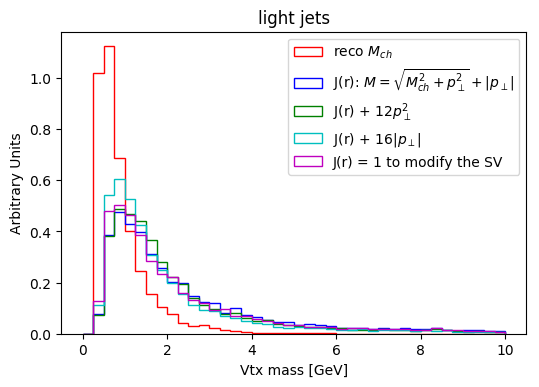

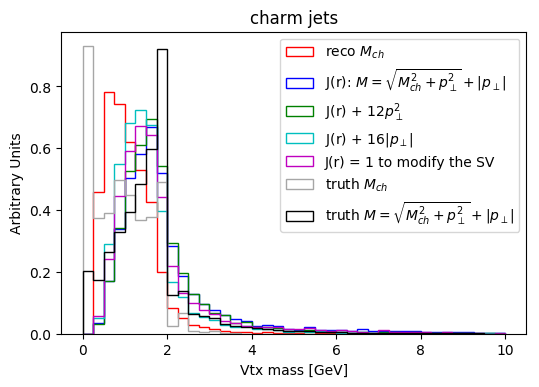

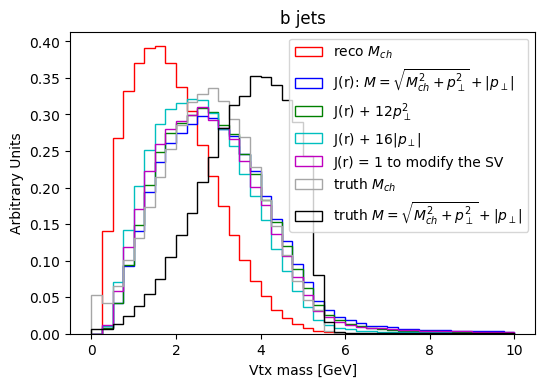

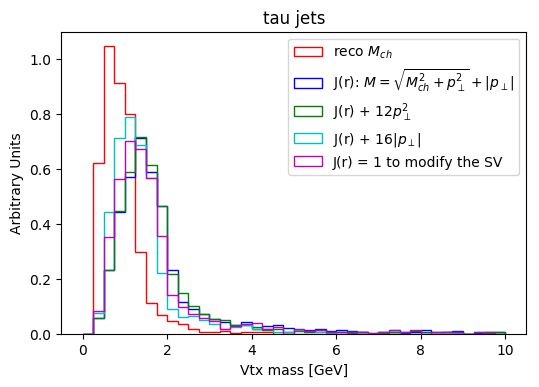

In [121]:
pdg_ids = [0,4,5,15]
titles  = ['light jets','charm jets','b jets','tau jets']

min = 0
max = 10
Nbins = 40
range = (min,max)

for pdg_id,title in zip(pdg_ids,titles):

    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['m_ch'][sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $M_{ch}$', color='r',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r): $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='b',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_alpha12'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_beta16'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_z1'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1 to modify the SV'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)
    
    if pdg_id == 4 or pdg_id == 5:
        
        hadron = 'b' if pdg_id == 5 else 'c'
        
        plt.hist(truth_df.loc[hadron]['m_ch'],
                 label='truth $M_{ch}$', color='0.65', # grey
                 histtype='step',bins=Nbins,range=range,normed=True)
        plt.hist(truth_df.loc[hadron]['m'],
                 label='truth $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='k',
                 histtype='step',bins=Nbins,range=range,normed=True)
    
    # prettify your histograms
    plt.xlabel('Vtx mass [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()



# Mitigating the tails:
To try to mitigate the tails on these distributions, implement the $M < 2*M_{ch}$ cut and see if this can help clean up the tails at all.

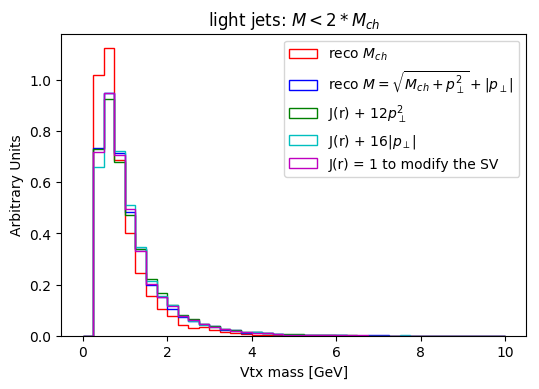

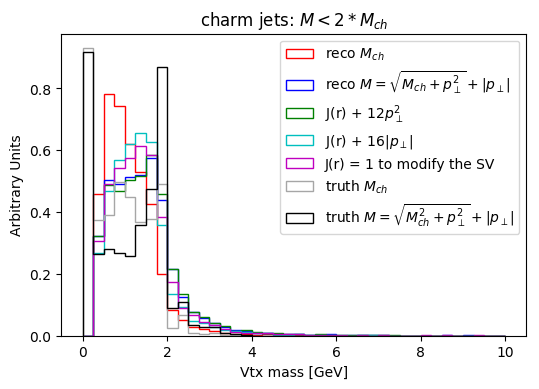

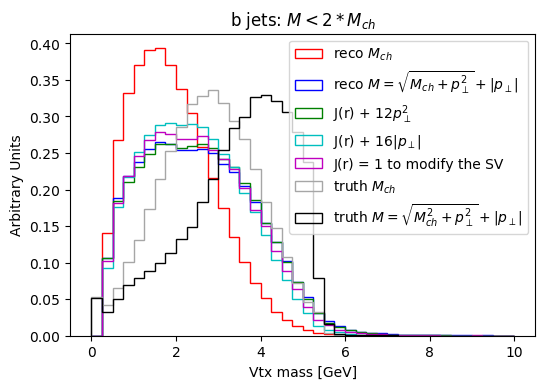

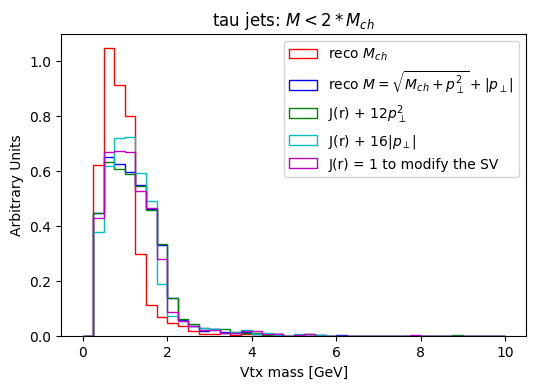

In [122]:
for pdg_id,title in zip(pdg_ids,titles):

    title = "{0}: {1}".format(title,'$M < 2*M_{ch}$')
    
    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['m_ch'][sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $M_{ch}$', color='r',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m'].where(sv1_df_flat['m'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $M = \sqrt{M_{ch} + p_\perp^2} + |p_\perp|$', color='b',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_alpha12'].where(sv1_df_flat['m_alpha12'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_beta16'].where(sv1_df_flat['m_beta16'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_z1'].where(sv1_df_flat['m_z1'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1 to modify the SV'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)
    
    if pdg_id == 4 or pdg_id == 5:
        
        hadron = 'b' if pdg_id == 5 else 'c'
        
        plt.hist(truth_df.loc[hadron]['m_ch'],
                 label='truth $M_{ch}$', color='0.65', # grey
                 histtype='step',bins=Nbins,range=range,normed=True)
        plt.hist(truth_df.loc[hadron]['m'].where(truth_df.loc[hadron]['m'] < 2*truth_df.loc[hadron]['m_ch'],other=truth_df.loc[hadron]['m_ch']),
                 label='truth $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='k',
                 histtype='step',bins=Nbins,range=range,normed=True)
    
    # prettify your histograms
    plt.xlabel('Vtx mass [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()



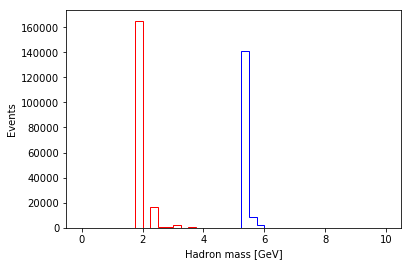

In [123]:
# Seeing how good we can possibly do... what is the actual hadron mass???
# I'm not overlaying these plots on the other one b/c they'd basically be delta functions, 
# so would obscure the other info that I'm trying to convey

plt.hist(truth_df.loc['b']['m_hadron'],color='b',
        histtype='step',bins=Nbins,range=range)
plt.hist(truth_df.loc['c']['m_hadron'],color='r',
         histtype='step',bins=Nbins,range=range)
plt.xlabel('Hadron mass [GeV]')
plt.ylabel('Events')
plt.show()


In [124]:
# Plot the p-perps for the various models

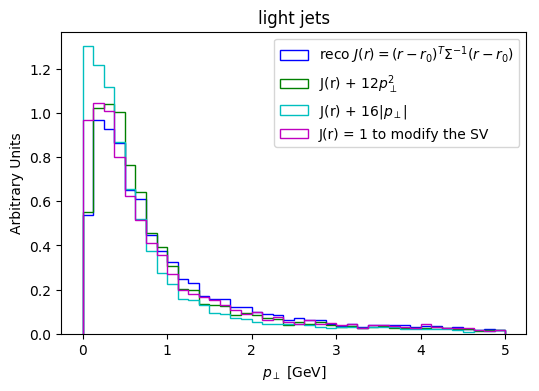

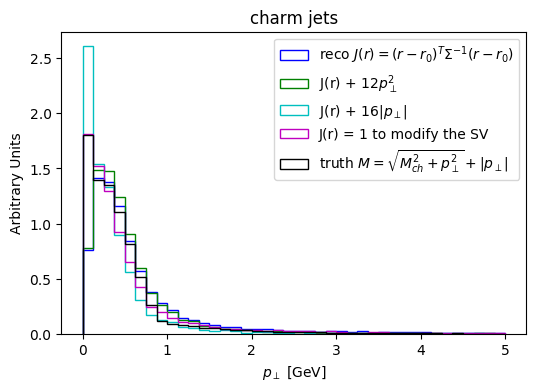

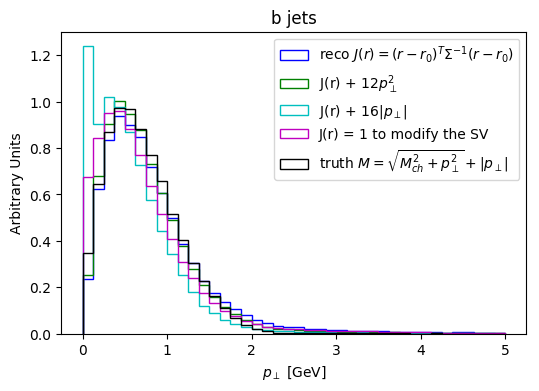

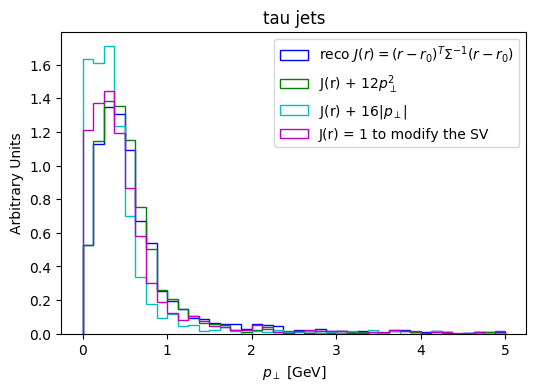

In [125]:
min = 0
max = 5
Nbins = 40
range = (min,max)

for pdg_id,title in zip(pdg_ids,titles):

    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $J(r) = (r-r_0)^T \Sigma^{-1} (r-r_0)$', color='b',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_alpha12'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_beta16'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_z1'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1 to modify the SV'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)
    
    if pdg_id == 4 or pdg_id == 5:
        
        hadron = 'b' if pdg_id == 5 else 'c'
        
        plt.hist(truth_df.loc[hadron]['pt'],
                 label='truth $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='k',
                 histtype='step',bins=Nbins,range=range,normed=True)
    
    # prettify your histograms
    plt.xlabel('$p_\perp$ [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()



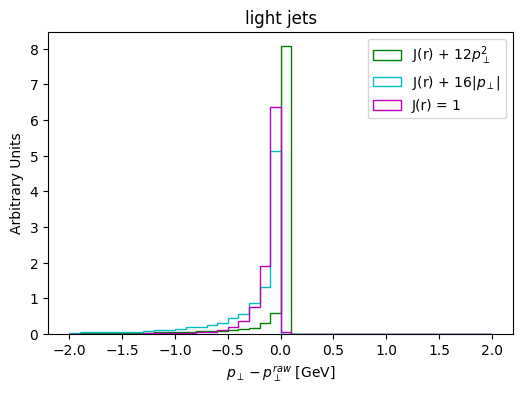

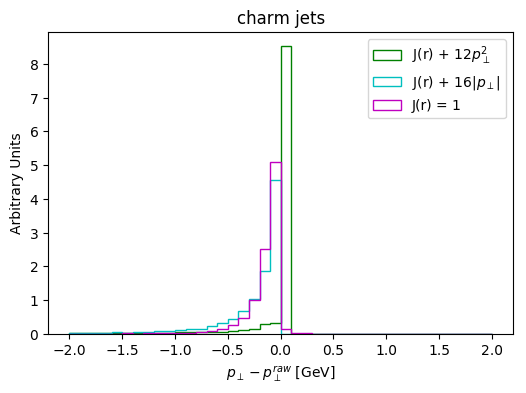

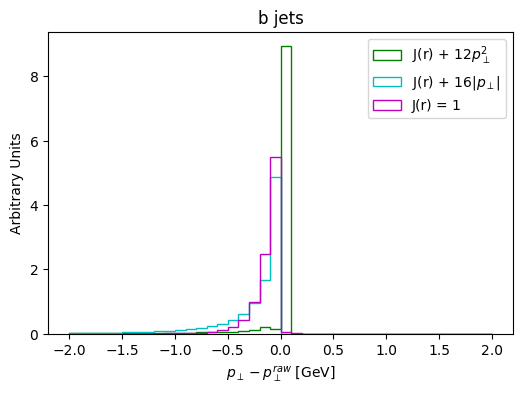

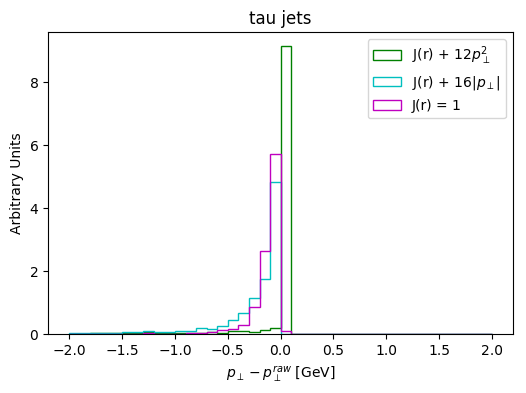

In [126]:
# Plot p-perp - p_perp for the nominal cost function

min = -2
max = 2
Nbins = 40
range = (min,max)

for pdg_id,title in zip(pdg_ids,titles):

    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['pt_alpha12'][sv1_df_flat['jet_pdg']==pdg_id] - sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_beta16'][sv1_df_flat['jet_pdg']==pdg_id] - sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_z1'][sv1_df_flat['jet_pdg']==pdg_id] - sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)

    # prettify your histograms
    plt.xlabel('$p_\perp - p_\perp^{raw}$ [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()